# Stack Overflow Search based on Questions Title

## Objectives

1. Building a search on stack overflow questions that returns similar set of questions.
2. Search should include semantic meaning of words.

## Constraints

1. Results should be displayed within a few seconds.

## Initial Steps

1. Perform EDA on Question Text data
2. Remove html tags
3. Clean data and remove special hidden characters
4. Use simple Tokenization Techniques and find cosine distance to return similar questions

## Importing Modules

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances

## Taking data from .db file to DataFrame

In [2]:
con = sqlite3.connect('train_no_dup.db')
num_rows = pd.read_sql_query("""SELECT title,tags FROM no_dup_train""", con)
data=pd.DataFrame(num_rows)

In [3]:
data.head()

,Title,Tags
0,Implementing Boundary Value Analysis of S...,c++ c
1,Dynamic Datagrid Binding in Silverlight?,c# silverlight data-binding
2,Dynamic Datagrid Binding in Silverlight?,c# silverlight data-binding columns
3,java.lang.NoClassDefFoundError: javax/serv...,jsp jstl
4,java.sql.SQLException:[Microsoft][ODBC Dri...,java jdbc


In [4]:
data_question=data['Title']

## Preprocessing Text

In [5]:
len(data_question)

4206315

<I><B>We have 4.2 million data points</B></I>

### Visualising some exactly duplicate questions

In [6]:
data_question[data_question.duplicated()].head()

2               Dynamic Datagrid Binding in Silverlight?
261     In OCaml, is it possible to define Map in ter...
293     Looking for an html element/property that sho...
318        ON DUPLICATE KEY UPDATE implementation/design
323     POST after copy project and change package na...
Name: Title, dtype: object

### Removing duplicate questions

In [7]:
data_question=data_question.drop_duplicates()

In [9]:
print('After removing Duplicate Questions we are left with',round(((len(data_question)/len(data['Title']))*100),2),'% data')

After removing Duplicate Questions we are left with 98.07 % data


### After removing Duplicate Questions we are left with 98.07 % data

In [463]:
data_question[10:20]

11      java.lang.NoSuchMethodError: javax.servlet.S...
12      obtaining updated locations using gps in ser...
13     "Specified initialization vector (IV) does no...
14     "Uncaught TypeError: Property 'addListGroup' ...
15            "subquery returns more than 1 row" error.
16             "while( !feof( file ) )" is always wrong
17     $ \sum\limits_{i=1}^{p-1} \Bigl( \Bigl\lfloor...
18     $5^{x}+2^{y}=2^{x}+5^{y} =\frac{7}{10}$ Work ...
19     $\mathbb{Z}_m \oplus \mathbb{Z}_n$ isomorphic...
20     $\mathcal{B}_3$ modulo the normal closure of ...
Name: Title, dtype: object

In [16]:
len(data_question)

4125234

In [11]:
#function to normalize text into a similar format
import re
def decontracted(phrase):
    phrase=phrase.lower()
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase=phrase.strip()    
    return phrase

In [ ]:
phrase=re.sub('[^A-Za-z0-9-+]+', ' ',phrase)

In [12]:
decontracted(data_question[4206311])

'� (question mark) getting displayed in place of inverted comma while getting text from mysql database php'

In [13]:
from tqdm import tqdm
processed=[]
for i in tqdm(data_question):
    processed.append(decontracted(i))

100%|████████████████████████████████████████████████████████████████████| 4125234/4125234 [00:38<00:00, 106520.83it/s]


In [464]:
processed[0:10]

['implementing boundary value analysis of software testing in a c++ program?',
 'dynamic datagrid binding in silverlight?',
 'java.lang.noclassdeffounderror: javax/servlet/jsp/tagext/taglibraryvalidator',
 'java.sql.sqlexception:[microsoft][odbc driver manager] invalid descriptor index',
 'better way to update feed on fb with php sdk',
 'btnadd click event opens two window after record added',
 '"sql injection" issue preventing correct form submission - php',
 'countable subadditivity of the lebesgue measure',
 'hql equivalent to this sql query',
 'undefined symbols for architecture i386: _objc_class_$_skpsmtpmessage", referenced from: error']

In [15]:
len(processed)

4125234

# Analysis of Tags

In [465]:
data['Tags'][0:10]

4337             c#
18069          java
27249           php
18157    javascript
1234        android
18608        jquery
4346            c++
29101        python
17643        iphone
2215        asp.net
Name: Tags, dtype: object

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())

#### Code to count the frequecy of tags

In [27]:
a=[]
for i in range (0,(len(data['Tags']))):
    b=data['Tags'][i].split()
    a.extend(b)

c=CountVectorizer(tokenizer = lambda x: x.split(',')) #Splitting on comma
d = c.fit_transform(a) #Transforming data on 42k tags
count=d.sum(axis=0) #Finding sum of each tag
tags=c.get_feature_names()
count_1=np.array(count) #Converting count matrix to numpy array
tags_1=list(tags)

#Making a DataFrame of Tag and tag count
tag_count=pd.DataFrame()
tag_count['Tags']=tags_1
tag_count['Count']=count_1[0]

#Sorting descending as per tag count
tag_count_1=tag_count.sort_values(by='Count',ascending=False)

tag_counts=tag_count_1['Count'].values

In [83]:
tag_count_1.to_pickle('Tag_Count.pickle')

In [469]:
tag_count_1.head(20)

,Tags,Count
4337,c#,331505
18069,java,299414
27249,php,284103
18157,javascript,265423
1234,android,235436
18608,jquery,221533
4346,c++,143936
29101,python,134137
17643,iphone,128681
2215,asp.net,125651


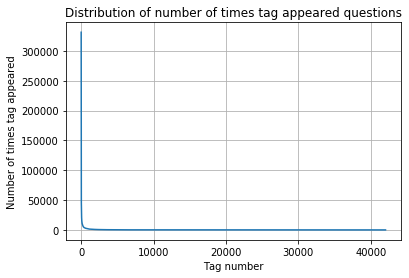

In [80]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

### We cannot make out anything from all tags. So we zoom in.

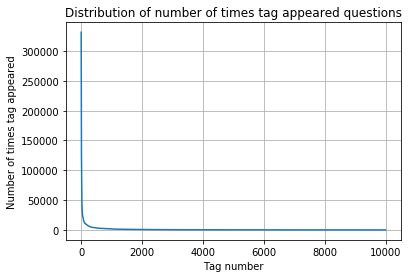

In [88]:
plt.plot(tag_counts[0:10000])
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

### Cant find much after zoom in to 10000 points. Hence zooming in further.

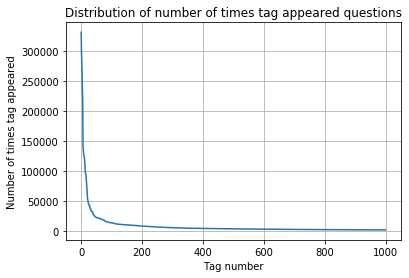

In [89]:
plt.plot(tag_counts[0:1000])
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

### Here we see, only few tags are used many times out of which C# is used 331505 times. 

### Experimenting with top 200 tags

In [160]:
tag_count_1[0:200]

,Tags,Count
4337,c#,331505
18069,java,299414
27249,php,284103
18157,javascript,265423
1234,android,235436
...,...,...
32599,servlets,8163
14750,grails,8143
15326,haskell,8138
18692,jquery-mobile,8138


### From top 200 tags, we try to find if there are some tags that are present in the question body. If yes, we will take those tags and save it in an additional column as Token.

In [106]:
len(processed)

4125234

In [471]:
processed[0:10]

['implementing boundary value analysis of software testing in a c++ program?',
 'dynamic datagrid binding in silverlight?',
 'java.lang.noclassdeffounderror: javax/servlet/jsp/tagext/taglibraryvalidator',
 'java.sql.sqlexception:[microsoft][odbc driver manager] invalid descriptor index',
 'better way to update feed on fb with php sdk',
 'btnadd click event opens two window after record added',
 '"sql injection" issue preventing correct form submission - php',
 'countable subadditivity of the lebesgue measure',
 'hql equivalent to this sql query',
 'undefined symbols for architecture i386: _objc_class_$_skpsmtpmessage", referenced from: error']

In [116]:
stopwords_1 = stopwords.words("english")
cleaned=[]

In [117]:
for sentance in tqdm(processed):
    sent = re.sub('[^A-Za-z0-9-+]+', ' ', sentance)
    sent = ' '.join(e for e in sent.split() if e not in stopwords_1)
    cleaned.append(sent)

100%|█████████████████████████████████████████████████████████████████████| 4125234/4125234 [01:14<00:00, 55455.65it/s]


In [472]:
cleaned[0:10]

['implementing boundary value analysis software testing c++ program',
 'dynamic datagrid binding silverlight',
 'java lang noclassdeffounderror javax servlet jsp tagext taglibraryvalidator',
 'java sql sqlexception microsoft odbc driver manager invalid descriptor index',
 'better way update feed fb php sdk',
 'btnadd click event opens two window record added',
 'sql injection issue preventing correct form submission - php',
 'countable subadditivity lebesgue measure',
 'hql equivalent sql query',
 'undefined symbols architecture i386 objc class skpsmtpmessage referenced error']

### In cleaned, we are storing the cleaned values by removing special characters, tags, punctuations so that we can vectorize them perfectly

In [235]:
aa=tag_count_1['Tags'][0:200]

In [190]:
aa

4337                c#
18069             java
27249              php
18157       javascript
1234           android
             ...      
32599         servlets
14750           grails
15326          haskell
18692    jquery-mobile
7042         core-data
Name: Tags, Length: 200, dtype: object

### In this part of code, we are taking top 4M data points and finding the tokens as per tags data

In [242]:
cleaned1=cleaned[0:4000000]
gg=[]
ff=[]
for k in (range(0,len(cleaned1))):
    q=cleaned[k].split()
    for i in aa:
        for j in q:
            if (i==j):
                gg.append(i)
    ff.append(gg)
    gg=[]


In [243]:
len(ff)

4000000

In [473]:
ff[0:10]

[['c++', 'testing'],
 ['silverlight'],
 ['java', 'jsp'],
 ['java', 'sql'],
 ['php'],
 [],
 ['php', 'sql'],
 [],
 ['sql', 'query'],
 ['class']]

In [246]:
data_main=pd.DataFrame()
data_main['Cleaned_Title']=cleaned1
data_main['Tokens']=ff
data_main['Title']=processed[0:4000000]

In [309]:
data_main.head()

,Title,Tokens,Cleaned_Title
0,implementing boundary value analysis of softwa...,"[c++, testing]",implementing boundary value analysis software ...
1,dynamic datagrid binding in silverlight?,[silverlight],dynamic datagrid binding silverlight
2,java.lang.noclassdeffounderror: javax/servlet/...,"[java, jsp]",java lang noclassdeffounderror javax servlet j...
3,java.sql.sqlexception:[microsoft][odbc driver ...,"[java, sql]",java sql sqlexception microsoft odbc driver ma...
4,better way to update feed on fb with php sdk,[php],better way update feed fb php sdk


In [310]:
data_main.to_pickle('4M_data_tokens_extracted.pickle')

### Now we are trying to remove the data points which do not have any token. That is that have an empty list.

In [302]:
data_1=data_main
data_main_clean=data_1[data_1.astype('str')['Tokens']!='[]']

In [348]:
data_main_clean

,Title,Tokens,Cleaned_Title
0,implementing boundary value analysis of softwa...,"[c++, testing]",implementing boundary value analysis software ...
1,dynamic datagrid binding in silverlight?,[silverlight],dynamic datagrid binding silverlight
2,java.lang.noclassdeffounderror: javax/servlet/...,"[java, jsp]",java lang noclassdeffounderror javax servlet j...
3,java.sql.sqlexception:[microsoft][odbc driver ...,"[java, sql]",java sql sqlexception microsoft odbc driver ma...
4,better way to update feed on fb with php sdk,[php],better way update feed fb php sdk
...,...,...,...
3999988,scrolling listview causes buttons to be invisible,[listview],scrolling listview causes buttons invisible
3999990,scrolling menu ( c code ),[c],scrolling menu c code
3999991,scrolling menu bar in iphone,[iphone],scrolling menu bar iphone
3999996,scrolling on touch devices for phonegap/cordov...,[phonegap],scrolling touch devices phonegap cordova projects


In [315]:
data_main_clean['Title'][1]

'dynamic datagrid binding in silverlight?'

In [479]:
print('After considering top 200 tags tokens we are left with',round(((len(data_main_clean)/len(data))),2),'% of data')

After considering top 200 tags tokens we are left with 56.13 % of data


### After considering top 200 tags tokens we are left with 56.13 % of data

In [480]:
print('Number of data poitns left are ',len(data_main_clean))

Number of data poitns left are  2360073


### As a feature engineering aspect, I am trying to consider the length of title

In [351]:
z=[]
for i in data_main_clean['Title'].values:
    z.append(len(i))

In [352]:
data_main_clean['Title_Length']=z

In [353]:
data_main_clean

,Title,Tokens,Cleaned_Title,Title_Length
0,implementing boundary value analysis of softwa...,"[c++, testing]",implementing boundary value analysis software ...,74
1,dynamic datagrid binding in silverlight?,[silverlight],dynamic datagrid binding silverlight,40
2,java.lang.noclassdeffounderror: javax/servlet/...,"[java, jsp]",java lang noclassdeffounderror javax servlet j...,76
3,java.sql.sqlexception:[microsoft][odbc driver ...,"[java, sql]",java sql sqlexception microsoft odbc driver ma...,79
4,better way to update feed on fb with php sdk,[php],better way update feed fb php sdk,44
...,...,...,...,...
3999988,scrolling listview causes buttons to be invisible,[listview],scrolling listview causes buttons invisible,49
3999990,scrolling menu ( c code ),[c],scrolling menu c code,25
3999991,scrolling menu bar in iphone,[iphone],scrolling menu bar iphone,28
3999996,scrolling on touch devices for phonegap/cordov...,[phonegap],scrolling touch devices phonegap cordova projects,56


In [359]:
z=list(data_main_clean['Title_Length'])

In [360]:
z.sort(reverse=True)

### Graph of Count of points vs Title_Length

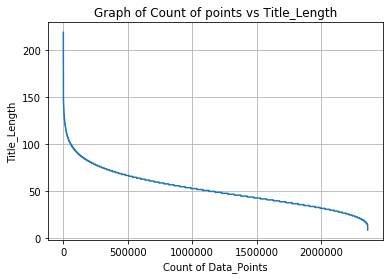

In [476]:
plt.plot(z)
plt.title("Graph of Count of points vs Title_Length")
plt.grid()
plt.xlabel("Count of Data_Points")
plt.ylabel("Title_Length")
plt.show()

### From the plot we see that the average length of question title is 40-80. Hence we select the point with having that range of length.

In [378]:
data_main_clean_v1=data_main_clean[data_main_clean['Title_Length']>40]
data_main_clean_v2=data_main_clean_v1[data_main_clean_v1['Title_Length']<80]

In [482]:
data_main_clean_v2.head()

,Title,Tokens,Cleaned_Title,Title_Length
0,implementing boundary value analysis of softwa...,"[c++, testing]",implementing boundary value analysis software ...,74
2,java.lang.noclassdeffounderror: javax/servlet/...,"[java, jsp]",java lang noclassdeffounderror javax servlet j...,76
3,java.sql.sqlexception:[microsoft][odbc driver ...,"[java, sql]",java sql sqlexception microsoft odbc driver ma...,79
4,better way to update feed on fb with php sdk,[php],better way update feed fb php sdk,44
6,"""sql injection"" issue preventing correct form ...","[php, sql]",sql injection issue preventing correct form su...,62


In [387]:
data_main_clean_v2['Cleaned_Title'][0]

'implementing boundary value analysis software testing c++ program'

#### Reset index of dataframe

In [395]:
data_main_clean_v3=data_main_clean_v2.reset_index()

In [481]:
data_main_clean_v3.head()

,index,Title,Tokens,Cleaned_Title,Title_Length
0,0,implementing boundary value analysis of softwa...,"[c++, testing]",implementing boundary value analysis software ...,74
1,2,java.lang.noclassdeffounderror: javax/servlet/...,"[java, jsp]",java lang noclassdeffounderror javax servlet j...,76
2,3,java.sql.sqlexception:[microsoft][odbc driver ...,"[java, sql]",java sql sqlexception microsoft odbc driver ma...,79
3,4,better way to update feed on fb with php sdk,[php],better way update feed fb php sdk,44
4,6,"""sql injection"" issue preventing correct form ...","[php, sql]",sql injection issue preventing correct form su...,62


In [460]:
data_main_clean_v3.to_pickle('data_main_clean_v3.pickle')

In [483]:
print('After considering title length between 40-80 we are left with',round(((len(data_main_clean_v3)/len(data))),2),'% of data')

After considering title length between 40-80 we are left with 33.21 % of data


### After considering title length between 40-80 we are left with 33.21 % of data

In [484]:
print('Number of data poitns left are ',len(data_main_clean_v3))

Number of data poitns left are  1396270


Observation:
1. Have not done lemmitization since it may change the meaning of words in title.(Eg C++ gets converted to C)